## Dimensionality reduction
We are interested in assessing how different dimensionality reduction techniques impact our cluster analyses.

1. Apply PCA and (if your computer's resources allow) another dimensionality reduction technique to visualize the data.
2. Change the parameters of the dimensionality reduction techniques (in particular, the number of components) to generate different latent spaces and assess how they impact cluster analysis. For this, select the best clustering algorithm that you identified in Assignment 01, and group samples together using the different latent spaces.
3. Compare each latent space in terms of its ability to group samples according to their tissue of origin.


### Load data

In [5]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
import umap 

In [10]:
# import data from 01_preprocessing jupyter notebook
GTEx_data = pd.read_pickle("../GTEx_data_input.pkl")
GTEx_labels = pd.read_pickle("../GTEx_labels.pkl")

### Visualize data using PCA and UMAP

#### PCA Visualizations

In [11]:
from sklearn.decomposition import PCA
# reduce GTEx data to a PCA of 50 dimensions
pca = PCA(n_components=50)
pca_fit = pca.fit(GTEx_data)
X = pca_fit.transform(GTEx_data)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(GTEx_labels)
y_lan = le.transform(GTEx_labels)

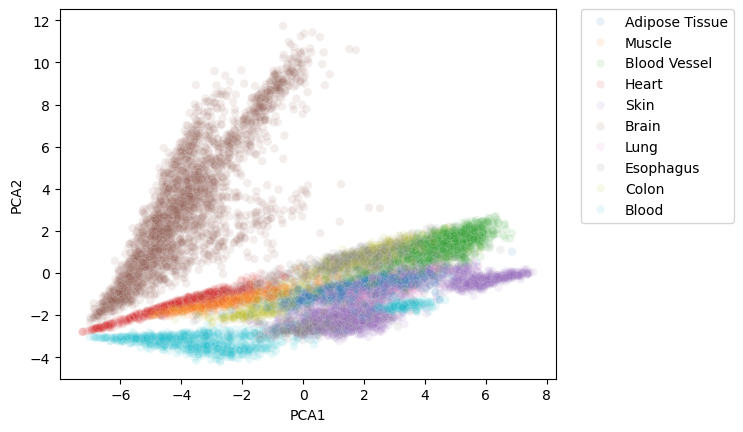

In [12]:
pca_df = pd.DataFrame({
    "PCA1": X[:, 0],
    "PCA2": X[:, 1],
    "Tissue": GTEx_labels,
    "label": y_lan
})
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Tissue", data=pca_df, alpha = 0.1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Do I have enough components?
Let's do something similar to the elbow method...

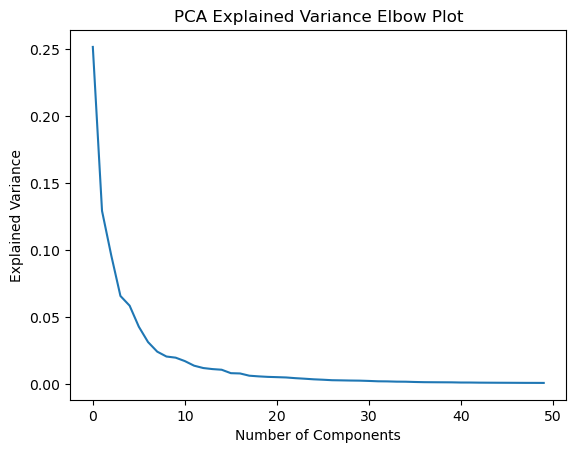

In [13]:
plt.plot(pca_fit.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance Elbow Plot')
plt.show()


By 10 PCA components, I'm explaining most of the variation in the data. 

#### UMAP Visualizations

In [14]:
# reduce data with UMAP, set seed because stochastic
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(GTEx_data)

/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


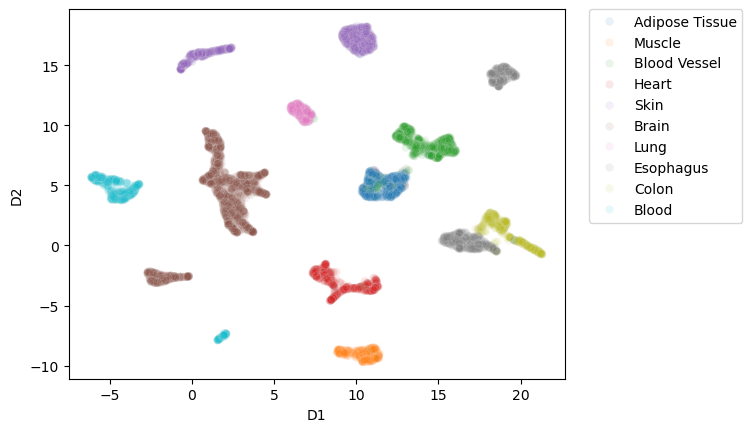

In [15]:
umap_df = pd.DataFrame({
    "D1": embedding[:, 0],
    "D2": embedding[:, 1],
    "Tissue": GTEx_labels,
    "label": y_lan
})
ax = sns.scatterplot(x="D1", y="D2", hue="Tissue", data=umap_df, alpha = 0.1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

There is much clearer separation of the types using UMAP when compared to the PCA.

### Dimension Reduction and Clustering

- Compare PCA n_components on clustering
- Compare umap n_neighbors on clustering (seems more interesting than n_components)
- Compare PCA > umap on clustering 

In [16]:
# PCA n_components on clustering analysis
# Define ranges for PCA components and clusters
Ks = range(10, 21, 5)
n_components_list = range(10, 51, 10)
# Initialize an empty list to store results
results = []

In [17]:
# Loop through PCA components
for n_components in n_components_list:
    
    # Fit PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(GTEx_data)
    
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
        part = model.fit_predict(X_pca)  # Predict using PCA-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_components": n_components,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

    n_components  k_clusters       ARI       AMI
0             10          10  0.582700  0.743207
1             10          15  0.578429  0.782224
2             10          20  0.562915  0.788531
3             20          10  0.556635  0.764299
4             20          15  0.641556  0.822053
5             20          20  0.588017  0.806843
6             30          10  0.509928  0.731077
7             30          15  0.630895  0.811120
8             30          20  0.600152  0.802241
9             40          10  0.476515  0.707017
10            40          15  0.601307  0.795755
11            40          20  0.593247  0.802825
12            50          10  0.527918  0.737708
13            50          15  0.617825  0.801033
14            50          20  0.557932  0.787344


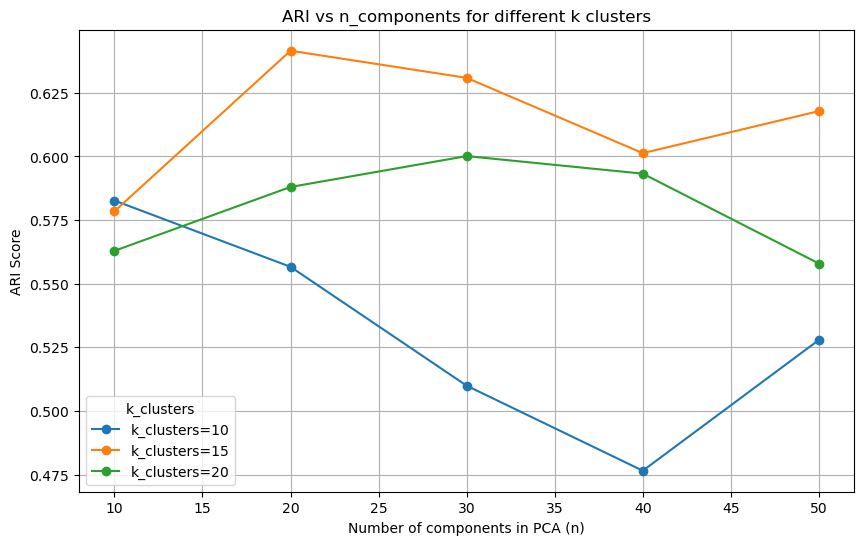

In [18]:
# plot results

# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

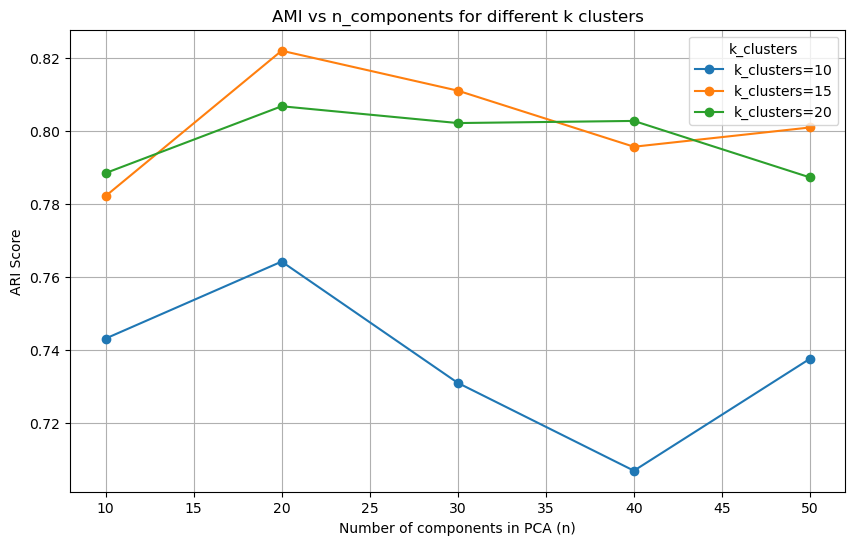

In [19]:
# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

Interestingly, 20 components appears to work better than adding additional components. The best k_clusters continues to be 15, similar to last time. 

In [ ]:
# UMAP n_neighbors on clustering analysis
# Define ranges for umap neighbors and clusters
Ks = range(10, 21, 5)
n_neighbors_list = (10, 20, 50, 100, 200)
# Initialize an empty list to store results
results = []

In [21]:
# Loop through Umap neighbors
for n_neighbor in n_neighbors_list:
    # Fit UMAP with the current number of neighbors
    # set seed because UMAP stochastic
    reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=n_neighbor)
    X_umap = reducer.fit_transform(GTEx_data)
    
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
        part = model.fit_predict(X_umap)  # Predict using UMAP-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_neighbor": n_neighbor,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils

    n_neighbor  k_clusters       ARI       AMI
0           10          10  0.677564  0.837412
1           10          15  0.698290  0.871273
2           10          20  0.612128  0.842783
3           20          10  0.692674  0.851956
4           20          15  0.697477  0.867456
5           20          20  0.613990  0.844819
6           50          10  0.700164  0.846964
7           50          15  0.673611  0.863747
8           50          20  0.590099  0.829092
9          100          10  0.698353  0.846201
10         100          15  0.668899  0.861934
11         100          20  0.586977  0.827985
12         200          10  0.650669  0.814497
13         200          15  0.709185  0.869682
14         200          20  0.605873  0.838016


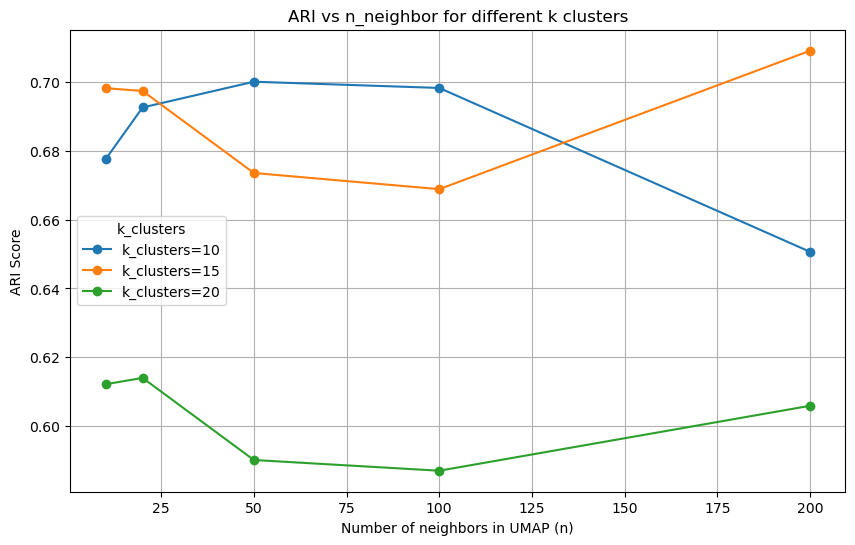

In [22]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

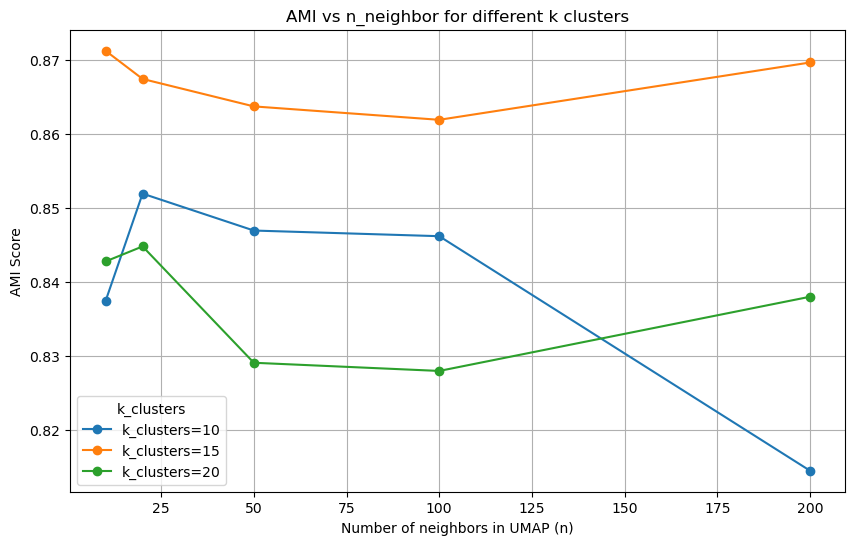

In [23]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("AMI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

Interestingly, 200 neighbors with 15 clusters appears to be the best. I wonder if that benefit keeps going if I add the number of neighbors? 

In [24]:
# Initialize n_neighbors and results lists
n_neighbors_list = range(200, 2000, 100)
# Initialize an empty list to store results
results = []

In [ ]:
# Loop through Umap neighbors
for n_neighbor in n_neighbors_list:
    # Fit UMAP with the current number of neighbors
    # set seed because UMAP stochastic
    reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=n_neighbor)
    X_umap = reducer.fit_transform(GTEx_data)
    model = cluster.AgglomerativeClustering(n_clusters=15, linkage="ward")
    part = model.fit_predict(X_umap)  # Predict using UMAP-transformed data
        
    # Compute performance metrics
    ari_score = ari(part, y_lan)
    ami_score = ami(part, y_lan)

    # Append results as a dictionary
    results.append({
        "n_neighbor": n_neighbor,
        "k_clusters": k,
        "ARI": ari_score,
        "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/katterwelp/miniconda3/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils

In [ ]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

In [ ]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("AMI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

I've seen that people run PCA first and then UMAP to help with the high dimensional problem... wonder if that's the case here?


In [ ]:
# UMAP on differing PCA latent spaces comparison
# PCA n_components on clustering analysis
# Define ranges for PCA components and clusters
Ks = range(10, 21, 5)
n_components_list = range(10, 51, 10)
# Initialize an empty list to store results
results = []

In [ ]:
# Loop through PCA components
for n_components in n_components_list:
    
    # Fit PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(GTEx_data)
    # Fit UMAP to PCA
    reducer = umap.UMAP(random_state=42, n_components=2)
    X_umap = reducer.fit_transform(X_pca)
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
        part = model.fit_predict(X_pca)  # Predict using PCA-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_components": n_components,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

In [ ]:
# plot results

# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

In [ ]:
# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()